# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

EPS = 1.0e-7

In [29]:
# PLEASE DO NOT REMOVE!
# The definition of the probability distribution.
mv1 = multivariate_normal(mean=[2.0, 2.0], cov=[[1.0, 0.5], [0.5, 1.0]])
mv2 = multivariate_normal(mean=[-3.0, -3.0], cov=[[1.0, 0.0], [0.0, 1.0]])


def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [30]:
# PLEASE DO NOT REMOVE!
# Calculating the probability distribution.
def calculate_p(x1, x2):
    p_x = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            p_x.append(prob(np.asarray([[x1[i], x2[j]]])))

    return np.asarray(p_x).reshape(len(x1), len(x2))

In [31]:
# PLEASE DO NOT REMOVE!
# Define coordinates
x1 = np.linspace(-10.0, 10.0, 400)
x2 = np.linspace(-10.0, 10.0, 400)

# Calculate the objective
p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

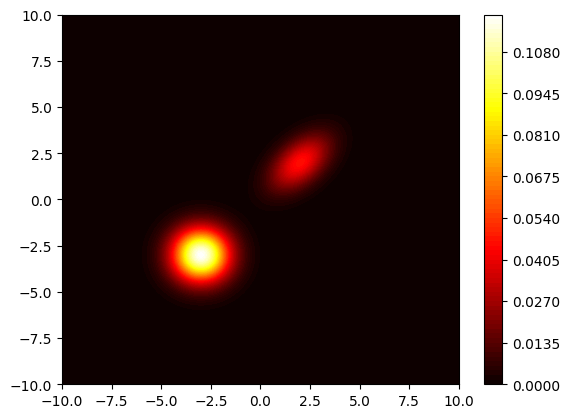

In [32]:
# PLEASE DO NOT REMOVE!
# Plot the objective
plt.contourf(x1, x2, p_x, 100, cmap="hot")
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:**
We have two modes, the most probable point is at -3,-3 because it has a higher probability density than the other one. And we have another mode at 2,2. They're the means of two normal distributions.

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:**
The proposal distribution in this case is a Gaussian distribution with mean at the current state (x_old) and a fixed standard deviation (std), i.e., $q(\mathbf{x}{new} | \mathbf{x}{old}) = 𝒩(\mathbf{x}{new} | \mathbf{x}{old},\mathbf{σ}^{2})$ , the mean is 0

**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:**
In order to determine if the proposal distribution is proper, we need to check if it fulfills irreducibility and aperiodicity. Because the updating of the new value of x is iterative and random, there is a chance that it will select any new point on the solution space and end up breaking the loop (aperiodicity). irreducebility means you can access any state from any other state and because theres randomness it is irreducible.

In [91]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# =========
# Implement the Metropolis Hastings (MH) algorithm.
# It might be you use another arguments beside standard deviation (std).
# Please add them then.

class MetropolisHastings(object):
    def __init__(self, x, prob, std=(0.1, 0.1)):
        # Constructor for the Metropolis-Hastings sampler
        self.prob = prob
        self.std = std
        self.x_old = x

    def proposal(self, x):
        # Propose a new candidate from the proposal distribution
        x_new = x + np.random.normal(scale=self.std, size=x.shape)
        return x_new

    def evaluate(self, x_new, x_old):
        # Evaluate the acceptance ratio for the candidate point, and it's a symmetric so you use the reduced formula.
        A = self.prob(x_new) / self.prob(x_old)
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        # Select the new point in the chain based on the acceptance ratio
        accept = np.random.rand() < A
        if accept:
            return x_new
        else:
            return self.x_old

    def step(self):
        # Take one step in the chain
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old)
        # 3. Select
        x_new = self.select(x_prop, A)
        self.x_old = x_new
        return x_new








In [92]:
# PLEASE DO NOT REMOVE!
# An auxiliary function for plotting.
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x / p_x.sum(), 100, cmap="hot")

    # Init the solution
    x_samp = sampler.x_old
    # Run the optimization algorithm
    count = 0  # we calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp, x), 0)

    ax.scatter(x_samp[:, 0], x_samp[:, 1], marker="+")
    # We add AR (Acceptance Rate) to the title.
    ax.set_title(title + " AR={:.2f}".format(count / num_epochs))

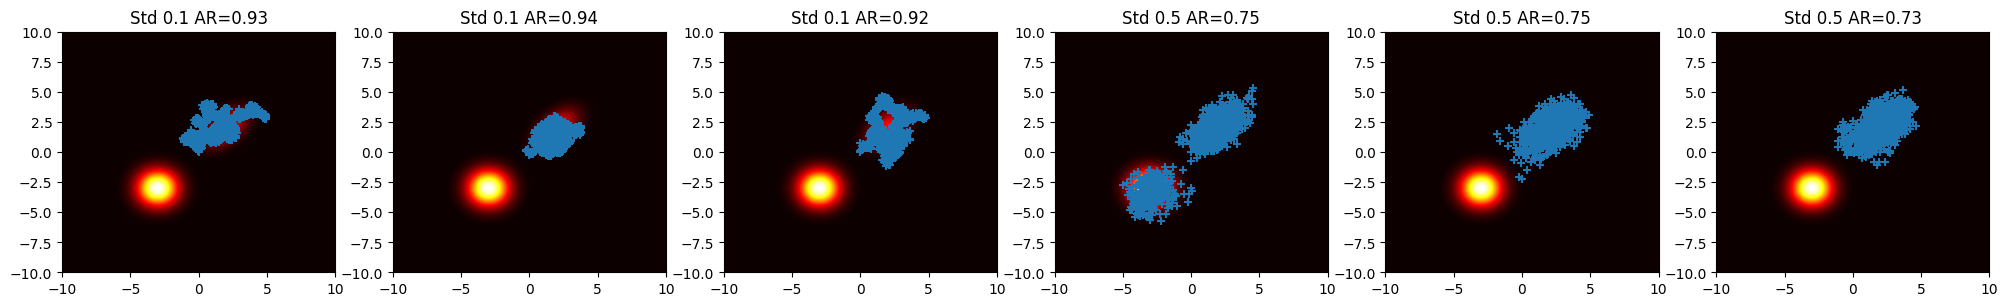

In [93]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]  # we repeat experiments 3 times per std
## If you add any other hyperparameters, please include them during init!
## However, please do not include them in the for-loop. It should stay for stds only.

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1, len(stds), figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0.0, 0.0]])

for i in range(len(stds)):
    # take the std
    std = stds[i]
    # init the MH
    mh = MetropolisHastings(x=x_init, prob=prob, std=std)
    # plot the convergence
    plot_sampling_process(axs[i], sampler=mh, title="Std " + str(mh.std))

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes theoretically? What did you observe in practice on plots? 

**Answer**: 
When the standard deviation is small, such as 0.1, and the algorithm converges to a local optima, a small step size may hinder the ability to escape this region. As a result, the algorithm may become trapped in this area, leading to the observed behavior. In contrast, a standard deviation of 0.5 allows for both local and global optima to be reached due to increased exploration.

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**: STD and AR are inverselyproportional to eachother. Larger std values would lead to a a larger variance and thus the sampled points moves further from the mean. We can get global optima by increasing the exploration, but also we have to accept fewer points because the current optima is less likely to be one of the sampled points.accept fewer points as current optima is less likely to be one of the smapled points.

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**: 
The Metropolis Hastings algorithm is a stochastic process that samples from a probability distribution to explore the search space, while Simulated Annealing algorithm is a heuristic optimization technique that uses a temperature parameter to control the probability of accepting worse solutions as it iteratively perturbs the current solution. In short, the main difference are the extra hyperparameters in  SA such as temperature.

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**: Simulated Annealing (SA) is sometimes more preferable than Metropolis Hastings (MH) because it can avoid getting trapped in local optima and can explore the search space more thoroughly (and we get to choose differemt values for T and C). This results it in it becoming a better algorithm for optimization.

If I were to use one of these two methods for optimization (not sampling), I would choose Simulated Annealing because it is a heuristic optimization technique that can find the global optimum by iteratively perturbing the current solution and avoiding getting stuck in local optima. However, the choice of algorithm depends on the problem being solved and its specific characteristics. In some cases, Metropolis Hastings may be more suitable, particularly when the objective function has a complex distribution or when the search space is high-dimensional.

In [100]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# NOTE: The cooling scheme must be properly implemented!
# =========
# Implement the Simulated Annealing (SA) algorithm.
# It is equivalent to implementing the step function.


class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1.0, C=1.0):
        
        #Initializes the simulated annealing algorithm with the starting position x, 
        #the probability distribution of the solution space prob, the standard deviation 
        #of the proposal distribution std, the initial temperature T0, and the cooling rate C.
        
        self.prob = prob
        self.std = std
        self.x_old = x
        self.T0 = T0
        self.C = C
        self.t = 0  # we init the step number to 0; we need it for cooling scheme

    def proposal(self, x):
        
        # Generates a new candidate solution by sampling from a normal distribution 
        # centered at the current solution with standard deviation self.std.
        
        x_new = np.random.normal(x, self.std)
        return x_new

    def evaluate(self, x_new, x_old, T):
        
        # Calculates the acceptance probability for the new candidate solution 
        # x_new given the current solution x_old and the current temperature T.
        
        # Calculate the acceptance probability using the formula
        A = (self.prob(x_new)**(1/T)) / (self.prob(x_old)**(1/T))
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        
        # Selects the next solution to be evaluated based on the acceptance probability A. 
        # If the acceptance probability is greater than a random number between 0 and 1, 
        # the new candidate solution x_new is selected as the current solution. Otherwise, 
        # the current solution remains the same.
        
        u = np.random.uniform()
        if u < A:
            x_selected = x_new
        else:
            x_selected = self.x_old
        # Update the current solution for the next iteration
        self.x_old = x_selected
        return x_selected

    def step(self):
        
        # Performs one iteration of the simulated annealing algorithm by generating a 
        # new candidate solution, evaluating the acceptance probability, and selecting 
        # the next solution to be evaluated.
        
        # The temperature scheme (the cooling scheme)
        T = self.C * np.log(self.t + self.T0) **-1
        self.t = self.t + 1
        # 1. Generate a new candidate solution
        x_prop = self.proposal(self.x_old)
        # 2. Calculate the acceptance probability
        A = self.evaluate(x_prop, self.x_old, T)
        # 3. Select the next solution
        x_new = self.select(x_prop, A)
        return x_new



/var/folders/1b/8pfxz1zj3873fx2q46gg6pz80000gn/T/ipykernel_30451/3639380265.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  T = self.C * np.log(self.t + self.T0) **-1


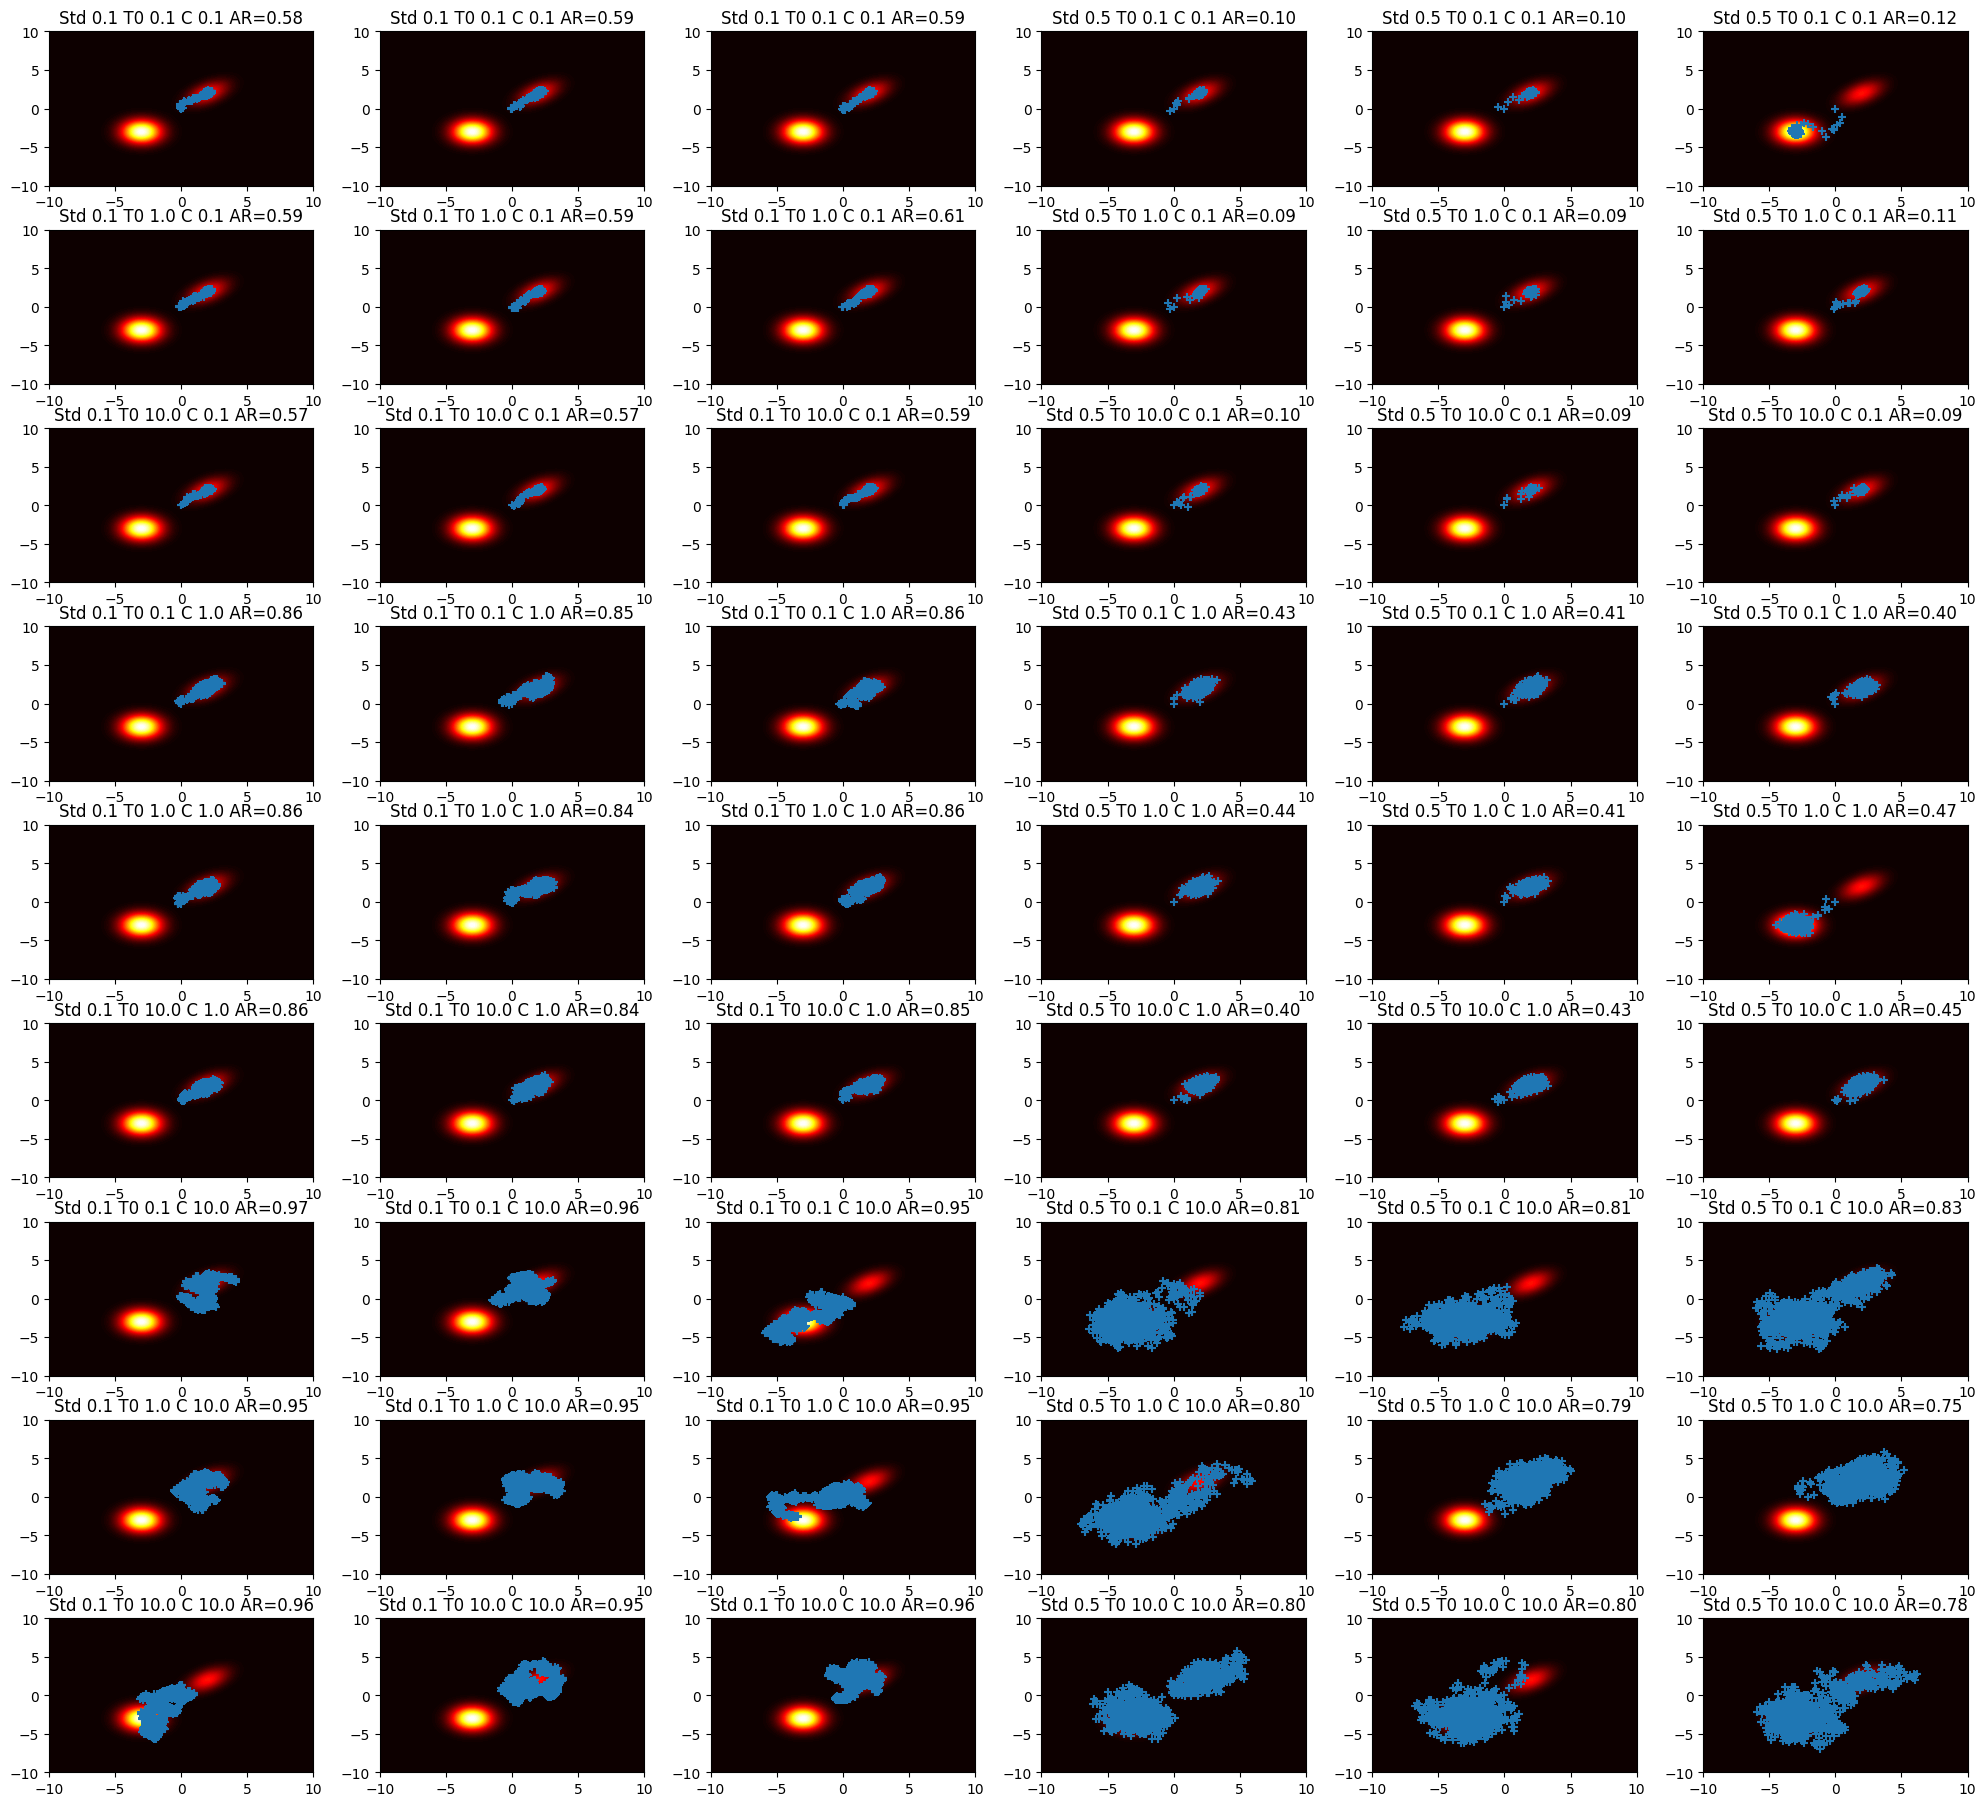

In [101]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds_sa = [
    0.1,
    0.1,
    0.1,
    0.5,
    0.5,
    0.5,
]  # values of std; notice we repeat them due to randomness
T0s = [0.1, 1.0, 10.0]  # values of T0
Cs = [0.1, 1.0, 10.0]  # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s), len(stds_sa), figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0.0, 0.0]])

# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
        # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(
                axs[len(T0s) * i + k, j],
                sampler=sa,
                title="Std " + str(sa.std) + " T0 " + str(T0) + " C " + str(C),
            )

**Question 8 (0-0.5pt)** How does the standard deviation influence the SA?

**Answer:** A smaller value of std results in smaller steps, this can cause the algorithm more likely to get stuck in local optima. A higher value of std will result in bigger steps and thus bigger exploration of the search space.

**Question 9 (0-0.5pt)** How does the initial temperature, $T_0$, influence the SA?

**Answer:** 
In Simulated Annealing (SA), a higher $T_0$ values result in a higher AR and allows it to explore worse solutions than current oen. also more exploration of the search space because the probability of accepting worse solutions is higher at the start of the SA process. Higher $T_0$ values allow the algorithm to avoid local optima and explore a larger region of the search space. Higher $T_0$ values, on the other hand, indicate that the algorithm will converge more slowly to the global optimum. Lower $T_0$ values, on the other hand, lead to less exploration of the search space because the probability of accepting worse solutions is lower at the start of the SA process. This means that lower $T_0$ values cause the algorithm to converge more quickly towards a local optimum but may prevent the algorithm from finding the global optimum.

As a result, the choice of $T_0$ is determined by the problem at hand and the trade-off between exploration and exploitation. In general, $T_0$ should be chosen high enough to allow for exploration but not so high that it prevents convergence towards the global optimum. The value of $T_0$ can be changed during the SA process in accordance with a predefined cooling schedule. 

**Question 10 (0-0.5pt)** How does the constant $C$ influence the SA?

**Answer:** The constant $C$ in the Simulated Annealing (SA) algorithm is also known as the cooling schedule and determines the rate at which the temperature decreases during the optimization process. We can see a higher value of $C$ leads to a slower decrease in temperature, which means that the algorithm explores the search space for longer periods of time. This can be useful when the search space is complex and a large number of iterations are needed to find the global optimum.

**Question 11 (0-0.5pt)** Which setting (i.e., std, $T_0$, $C$) did perform the best in terms of sampling?

**Answer:** in general, a setting that allows for efficient exploration of the search space and convergence to the global maximum of the objective function would be considered good. In the code provided, it appears that the SA algorithm with $C=10$, $T_0=1.0$, and std=0.5 achieves relatively good convergence and exploration of the search space.

**Question 12 (0-0.5pt)** How do different values of the hyperparameters (i.e., std, $T_0$, $C$) influence the acceptance ratio (AR)? Why?

**Answer:** std: dencreasing the value of std will be more likely that the acceptance ratio increases because of smaller variance accompaying it.

$T_0$ almost has no effect on AR as we can see.

a higher C is a smaller high AR because of the acceptance of less points it slows down slower but stays high thus it can allow the algorithm to explore a larger portion of the search space.

## 4. Final remarks: MH vs. SA

Eventually, please answer the following last questions that will allow you to conclude the assignment and draw conclusions.

**Question 13 (0-0.5-1pt)**: Which of the two algorithms did perform better? Why?

**Answer**: 
Because of its temperature hyperparameter, SA performed better than MHA. 
In SA, this results in a higher overall time allotted to exploration than in MHA. Thus, the chances of finding a global optima is also higher in SA as compared to MHA (due to lower chances of it getting stuck in a local optima) and hence, SA performs better.

**Question 14 (0-0.5-1pt)**: Which of the two algorithms is easier to use? Why?

**Answer**: MH uses a fixed probability distribution function and does not have a temperature parameter. The MH algorithm is generally easier to use than simulated annealing because it does not require the user to tune as many parameters. In the MH algorithm, the only required parameter is the proposal distribution, which determines the probability of moving from one solution to another. Once this distribution is chosen, the algorithm can be run without any further input from the user. In contrast, simulated annealing requires the user to specify the initial temperature, the cooling schedule, and the proposal function, which can be more difficult to choose.

